In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import layers
import tensorflow as tf
import re
from collections import Counter
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(1234)

In [3]:
df_movies = pd.read_csv('movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.shape

(9742, 3)

In [5]:
df_movies['movieId'].nunique()

9742

In [6]:
df_movies['title'].nunique()

9737

In [7]:
df_movies['title'].duplicated().any()

True

In [8]:
duplicates = df_movies.duplicated(subset=['title'], keep=False)

if duplicates.any():
  print(df_movies[['title', 'genres']].loc[duplicates])

                                       title  \
650                              Emma (1996)   
2141                         Saturn 3 (1980)   
4169  Confessions of a Dangerous Mind (2002)   
5601                             Emma (1996)   
5854                             Eros (2004)   
5931                War of the Worlds (2005)   
6932                War of the Worlds (2005)   
9106  Confessions of a Dangerous Mind (2002)   
9135                             Eros (2004)   
9468                         Saturn 3 (1980)   

                                   genres  
650                  Comedy|Drama|Romance  
2141            Adventure|Sci-Fi|Thriller  
4169          Comedy|Crime|Drama|Thriller  
5601                              Romance  
5854                                Drama  
5931     Action|Adventure|Sci-Fi|Thriller  
6932                        Action|Sci-Fi  
9106  Comedy|Crime|Drama|Romance|Thriller  
9135                        Drama|Romance  
9468                      Sci-F

In [9]:
# manually remove index 5601, 9468, 4169, 5854, 6932
df_movies = df_movies.drop([5601, 9468, 4169, 5854, 6932])
df_movies.shape

(9737, 3)

In [10]:
df_movies = df_movies.reset_index(drop=True)
df_movies.tail()
     

,movieId,title,genres
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9734,193585,Flint (2017),Drama
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9736,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [11]:
df_movies.columns = df_movies.columns.str.lower()
df_movies.head()

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
df_movies_new = df_movies.copy()

In [13]:
df_movies['genres'] = df_movies['genres'].str.replace('|',' ')

In [14]:
df_movies_new['genreslist'] = df_movies_new['genres'].apply(lambda x:x.split('|'))

In [15]:
df_movies_new['genres'] = df_movies_new['genres'].str.replace('|',' ')

In [16]:
df_movies_new.head()

,movieid,title,genres,genreslist
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure Children Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [17]:
genres = df_movies_new['genreslist'].apply(Counter)
genres.head()

0    {'Adventure': 1, 'Animation': 1, 'Children': 1...
1        {'Adventure': 1, 'Children': 1, 'Fantasy': 1}
2                          {'Comedy': 1, 'Romance': 1}
3              {'Comedy': 1, 'Drama': 1, 'Romance': 1}
4                                        {'Comedy': 1}
Name: genreslist, dtype: object

In [18]:
genres = pd.DataFrame.from_records(genres).fillna(value=0)
genres.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_movies_new = df_movies_new.join(genres)
df_movies_new.shape

(9737, 24)

In [20]:
df_movies_new = df_movies_new.drop(['genreslist'], axis=1)

In [21]:
df_movies_new.head(3)

,movieid,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure Children Fantasy,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy Romance,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_movies_new.columns

Index(['movieid', 'title', 'genres', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller',
       'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'],
      dtype='object')

In [23]:

df_movies_new[['Adventure', 'Animation', 'Children',
       'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller',
       'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)']] = df_movies_new[['Adventure', 'Animation', 'Children',
       'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller',
       'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)']].apply(pd.to_numeric, downcast='integer')

df_movies_new.head(3)

,movieid,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure Children Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_movies_new.rename(columns = {'Sci-Fi':'Sci_Fi', 'Film-Noir':'Film_Noir', '(no genres listed)':'No_Genres'}, inplace=True)
df_movies_new.columns = df_movies_new.columns.str.lower()

In [25]:
df_rating = pd.read_csv('ratings.csv')
df_rating.head()
     

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [26]:
df_rating.columns = df_rating.columns.str.lower()
df_rating.head()
     

,userid,movieid,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [27]:

df_tags = pd.read_csv('tags.csv')
df_tags.head()
     

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [28]:
df_tags.columns = df_tags.columns.str.lower()
df_tags.head()

,userid,movieid,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [29]:
movie_rating = pd.merge(df_movies_new, df_rating, on='movieid')
movie_rating.head(3)

,movieid,title,genres,adventure,animation,children,comedy,fantasy,romance,drama,...,war,musical,documentary,imax,western,film_noir,no_genres,userid,rating,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,4.0,964982703
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,5,4.0,847434962
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,7,4.5,1106635946


In [30]:
cols = movie_rating.columns[3:23].values.tolist()
movie_type = []
type_count = []

for col in cols:
  movie_type.append(col)
  type_count.append(movie_rating[col].value_counts()[1])

movie_type_count = pd.DataFrame(list(zip(movie_type, type_count)),
               columns =['movie_type', 'type_count'])
movie_type_count

,movie_type,type_count
0,adventure,24161
1,animation,6988
2,children,9208
3,comedy,39038
4,fantasy,11834
5,romance,18123
6,drama,41912
7,action,30633
8,crime,16666
9,thriller,26436


In [31]:
movie_type_count = movie_type_count.sort_values('type_count', ascending = False)

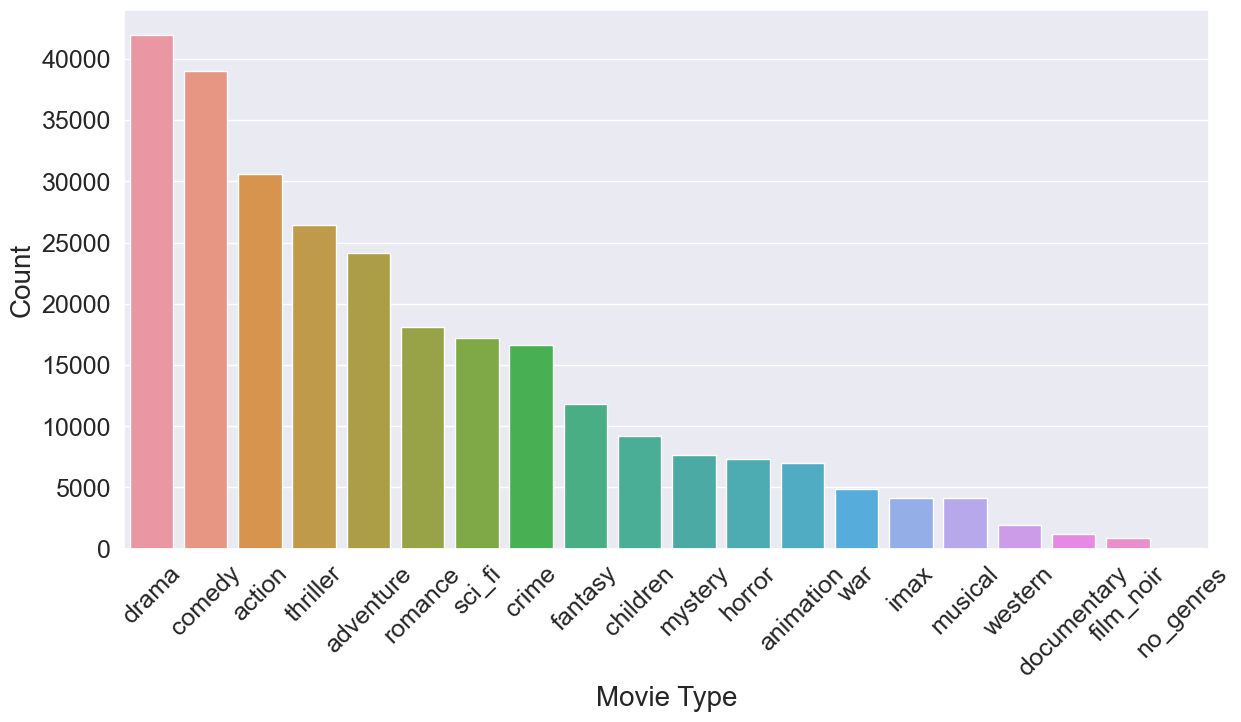

In [32]:
sns.set(rc={'figure.figsize':(14,7)})
ax = sns.barplot(x='movie_type', y='type_count', data=movie_type_count)
ax.set_xlabel('Movie Type', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='x', labelsize=18, rotation=45)
ax.tick_params(axis='y', labelsize=18)
plt.show()

In [33]:
df1 = movie_rating.groupby(['title']).agg({'rating':'mean'}).sort_values(by=['rating'],ascending=False).reset_index()
df1.head()

,title,rating
0,Vagabond (Sans toit ni loi) (1985),5.0
1,World of Glory (1991),5.0
2,Colourful (Karafuru) (2010),5.0
3,Come and See (Idi i smotri) (1985),5.0
4,When Worlds Collide (1951),5.0


In [34]:
df2 = movie_rating.groupby(['title']).agg({'rating':'count'}).sort_values(by=['rating'],ascending=False).reset_index()
df2.head()
     

,title,rating
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278


In [35]:

# users with most number of rating

movie_rating.groupby(['userid']).agg({'rating':'count'}).sort_values(by=['rating'],ascending=False).head().reset_index()

,userid,rating
0,414,2697
1,599,2477
2,474,2107
3,448,1864
4,274,1346


In [36]:
df = pd.merge(df1, df2, on='title')
df.columns = ['title', 'mean_rating', 'no_of_ratings']
dfn=df
df.head()

,title,mean_rating,no_of_ratings
0,Vagabond (Sans toit ni loi) (1985),5.0,1
1,World of Glory (1991),5.0,1
2,Colourful (Karafuru) (2010),5.0,1
3,Come and See (Idi i smotri) (1985),5.0,2
4,When Worlds Collide (1951),5.0,1


In [37]:
C = df['mean_rating'].mean()
C
     

3.2624701125899587

In [38]:

m = df['no_of_ratings'].quantile(0.7)
m

7.0

In [39]:

# considering only those movies eligible which has num of ratings > 70% quantile value

eligible = df.loc[df['no_of_ratings'] >= m]
eligible.shape

(2948, 3)

In [40]:

# calculation based on the IMDB formula

def weighted_rating(x, m=m, C=C):
    v = x['no_of_ratings']
    R = x['mean_rating']
    score = (v/(v+m) * R) + (m/(m+v) * C)
    return score

In [41]:
eligible['score'] = eligible.apply(weighted_rating, axis=1)
eligible.head()

,title,mean_rating,no_of_ratings,score
317,"Three Billboards Outside Ebbing, Missouri (2017)",4.750000,8,4.055819
340,Secrets & Lies (1996),4.590909,11,4.074294
341,"Day of the Doctor, The (2013)",4.571429,7,3.916949
342,Guess Who's Coming to Dinner (1967),4.545455,11,4.046516
343,Paths of Glory (1957),4.541667,12,4.070384


In [42]:
eligible = eligible.sort_values('score', ascending=False)

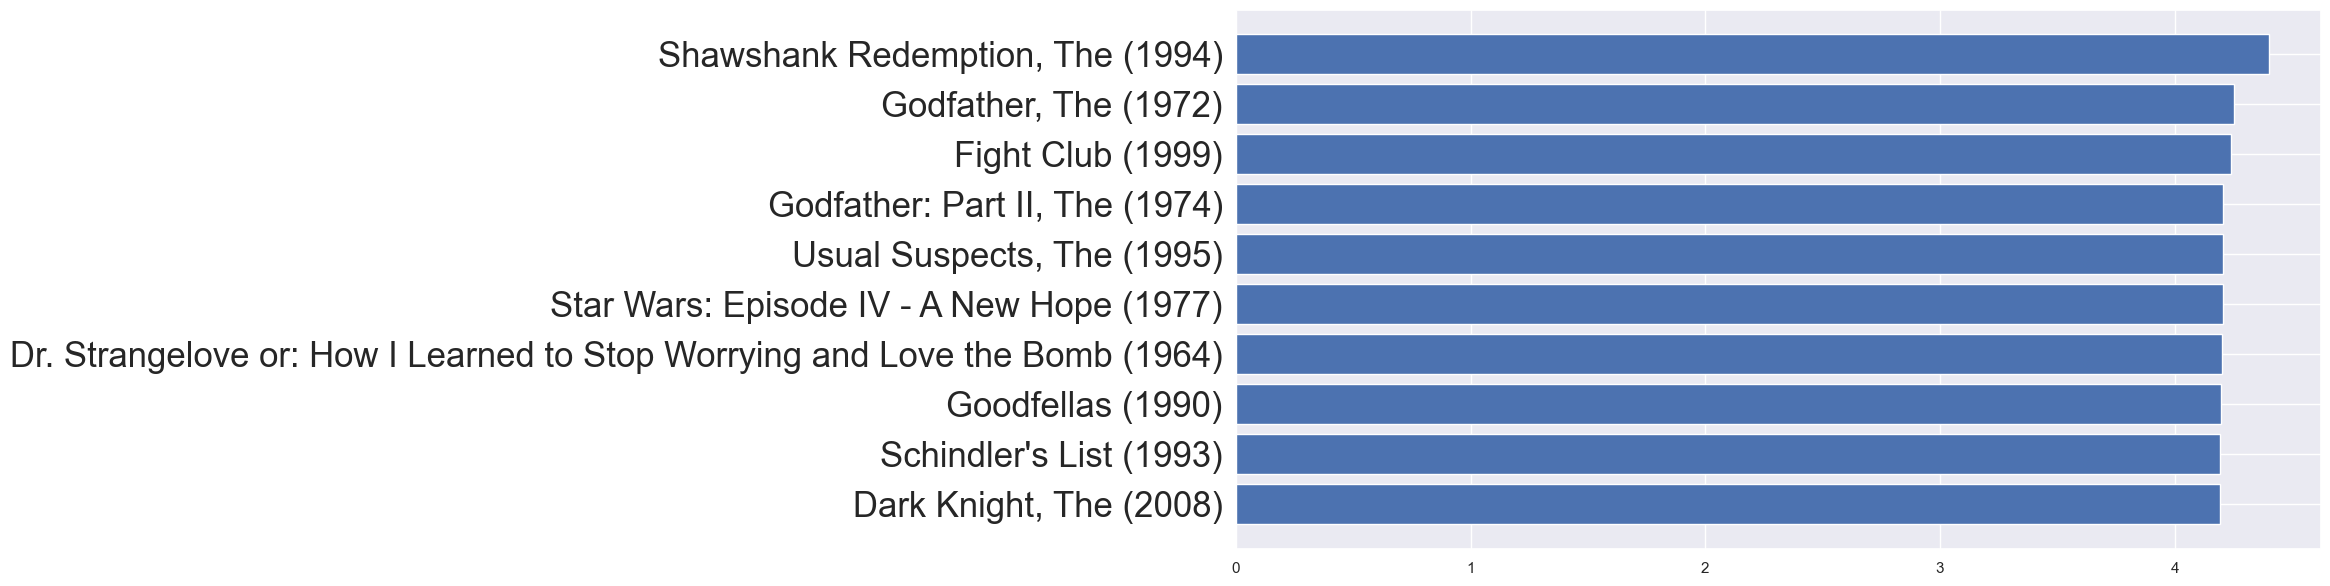

In [43]:
import matplotlib.pyplot as plt

plt.gca().invert_yaxis()
plt.barh(eligible['title'].head(10), eligible['score'].head(10), align='center')
plt.yticks(fontsize=25)
plt.show()


In [44]:
##### 1
